In [432]:
# 모듈 로딩
from urllib.request import urlopen,Request,urlretrieve
from bs4 import BeautifulSoup
from selenium import webdriver
from PIL import Image
# from sklearn.linear_model import LogisticRegression
# from sklearn.utils import all_estimators
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

## * 이미지 회전 시키기 => 데이터 증식

In [433]:
# 크롤링 데이터 로테이션시키는 함수
def rota_save(color,foldname):
    # 폴더 만들기
    if not os.path.exists('./'+foldname):
        os.makedirs(foldname)
    
    rotation=[45,90,135,180,225,270,315]    # 로테이션 각도
    for file in os.listdir('./data/'):
        for rot in rotation:
            img=np.array(Image.open('./data/'+file).convert(color))
            rows,cols = img.shape[0:2]
            ro_mt = cv2.getRotationMatrix2D((cols/2,rows/2),rot,1.42)
            ro_img = cv2.warpAffine(img, ro_mt,(cols, rows))
            
            # 이미지 저장
            filename=f"{file}_ro{str(rot)}"
            cv2.imwrite('./'+foldname+'/'+filename+'.png',ro_img)

In [434]:
# 크롤링 데이터 convert 함수
def data_con(color,foldname):
    for file in os.listdir('./data/'):
        img=Image.open('./data/'+file).convert(color).save('./'+foldname+'/'+file)

In [435]:
# 흑백으로 로테이션
rota_save('L','blwh')

# rgb로 로테이션
rota_save('RGB','rgb')

# 원본사진 흑백으로
data_con('L','blwh')

# 원본사진 색깔로
data_con('RGB','rgb')

## * 사진 데이터화 시키기

In [464]:
def solution(foldname):
    l=[]
    for i in os.listdir('./'+foldname+'/'):
        n=np.array(Image.open('./'+foldname+'/'+i))/255.0
        if foldname=='blwh':
           n_list=n.reshape(-1,50*50)[0].tolist()
        else:
            n_list=n.reshape(-1,50,50,3)[0].tolist()
        l.append(n_list)
    return np.array(l)

In [465]:
blwh=solution('blwh')
blwh

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.09411765, 0.59215686, 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.42352941, 0.98431373, 0.87058824, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.75294118, 0.52941176, 0.34901961, ..., 0.69803922, 0.83921569,
        0.97254902],
       [0.99215686, 0.99607843, 0.99607843, ..., 0.94509804, 0.99215686,
        0.99215686],
       [0.30980392, 0.30980392, 0.30980392, ..., 0.30980392, 0.30980392,
        0.30980392]])

In [466]:
rgb=solution('rgb')
rgb

array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]

In [467]:
# plt.imshow(blwh[3500].reshape(50,50,), cmap='gray')

In [468]:
# plt.imshow(rgb[3500].reshape(50,50,3), cmap='gray')

In [469]:
# input data
X1 = blwh
X2 = rgb

In [470]:
# target data
label = pd.read_csv('target.csv')
y = np.array(label.label)
y

array([ 0,  0,  0, ..., 25, 25, 25], dtype=int64)

## [1] 데이터 분리
---

In [471]:
# 크롤링해서 받을 때 이미 /255.0을 해 준 상태 (0~1) 사이로 바뀌어 있음
# 데이터가 적으므로 train, test 데이터만 분리
X_train, X_test, y_train, y_test = train_test_split(X2, y, stratify = y, random_state=42) #, test_size=0.2)

In [472]:
# 이미 함수로 /255.0을 해서 0~1 사이에 있는 상태
# reshape로 1차원으로 다 바뀌어져 있는 상태

print(f'X_train.shape : {X_train.shape}')  # 학습용
print(f'X_test.shape  : {X_test.shape}')   # 테스트용
print(f'y_train.shape : {y_train.shape}')
print(f'y_test.shape  : {y_test.shape}')

X_train.shape : (3234, 50, 50, 3)
X_test.shape  : (1078, 50, 50, 3)
y_train.shape : (3234,)
y_test.shape  : (1078,)


## [2] 모델 구성 및 생성
---

In [473]:
data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

In [496]:
model = tf.keras.Sequential([
    data_augmentation,
    layers.Conv2D(30, 3, activation="relu", padding="same", input_shape=(50,50,3)),
    layers.Conv2D(1, 3, activation="relu", padding="same")
#     layers.Flatten(),
#     layers.Dense(units=300, activation='relu'),
#     layers.Dense(500, activation = 'relu'),
#     layers.Dense(500, activation = 'relu'),
#     layers.Dense(7500, activation='sigmoid')
#     layers.Dense(26, activation='softmax')
])

In [497]:
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics='accuracy')

## [3] 모델 확인 및 시각화
---

In [476]:
# model.summary()
# # Model.summary()
# # print('\n\n')
# # Model2.summary()
# # print('\n\n')
# # Model3.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [485]:
X_train.shape

(3234, 50, 50, 3)

In [490]:
# 요걸 출력하면 안되는 것.
# -> y_train.shape

(3234,)

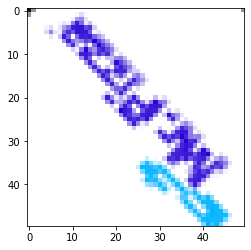

In [487]:
plt.imshow(X_train[0])

In [494]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, show_shapes=True)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

## [4] 학습
---

In [498]:
model.fit(X_train, X_train, epochs=10)

Epoch 1/10
102/102 [==============================] - 8s 55ms/step - loss: 0.5878 - accuracy: 0.3287
Epoch 2/10
102/102 [==============================] - 5s 53ms/step - loss: 0.5011 - accuracy: 0.3563
Epoch 3/10
102/102 [==============================] - 5s 53ms/step - loss: 0.5039 - accuracy: 0.3539
Epoch 4/10
102/102 [==============================] - 5s 52ms/step - loss: 0.4943 - accuracy: 0.3572
Epoch 5/10
102/102 [==============================] - 5s 53ms/step - loss: 0.4898 - accuracy: 0.3584
Epoch 6/10
102/102 [==============================] - 6s 54ms/step - loss: 0.4883 - accuracy: 0.3581
Epoch 7/10
102/102 [==============================] - 6s 54ms/step - loss: 0.4859 - accuracy: 0.3589
Epoch 8/10
102/102 [==============================] - 5s 54ms/step - loss: 0.4867 - accuracy: 0.3584
Epoch 9/10
102/102 [==============================] - 6s 54ms/step - loss: 0.4863 - accuracy: 0.3584
Epoch 10/10
102/102 [==============================] - 6s 55ms/step - loss: 0.4854 - accura

## [5] 평가
---

In [507]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

34/34 [==============================] - 1s 17ms/step - loss: -14.2072 - accuracy: 0.0297


[-14.207195281982422, 0.029743889346718788]

In [505]:
X_train[0].shape

(50, 50, 3)

## [6] 예측
---

In [500]:
predicted = model.predict(X_test)

34/34 [==============================] - 0s 5ms/step


In [504]:
X_test.shape

(1078, 50, 50, 3)

### [6-1] 정답확인 (테스트셋)
---

In [501]:
# 1) 정답지 DF로 만들기
label = pd.read_csv('target.csv')
df = pd.DataFrame(label.name.unique())
df['label'] = label.label.unique()
df.columns = ['Brand', 'Label']
df

,Brand,Label
0,angelinus,0
1,banolim,1
2,bbackdabang,2
3,benz,3
4,bmw,4
5,crown,5
6,cw,6
7,debec,7
8,domino,8
9,ediya,9


In [502]:
# 2) X_test와 그 결과(y_test)
# for i in range(len(X_test)):
for i in range(9):
    print(f'X_test ' + str(i) + f' : {predicted[i].argmax()}')
    print(f'y_test ' + str(i) + f' : {y_test[i]}')
    print(f"{df[df['Label'] == y_test[i]]}\n")

X_test 0 : 350
y_test 0 : 19
       Brand  Label
19  papazons     19

X_test 1 : 2400
y_test 1 : 4
  Brand  Label
4   bmw      4

X_test 2 : 2400
y_test 2 : 14
    Brand  Label
14  lotte     14

X_test 3 : 2400
y_test 3 : 11
     Brand  Label
11  haitai     11

X_test 4 : 1687
y_test 4 : 16
      Brand  Label
16  mrpizza     16

X_test 5 : 2400
y_test 5 : 1
     Brand  Label
1  banolim      1

X_test 6 : 1378
y_test 6 : 14
    Brand  Label
14  lotte     14

X_test 7 : 1350
y_test 7 : 12
      Brand  Label
12  hyundai     12

X_test 8 : 2400
y_test 8 : 9
   Brand  Label
9  ediya      9



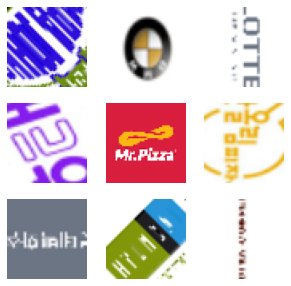

In [503]:
plt.figure(figsize=(5, 5))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i].reshape(50,50,3))
    plt.axis("off")    

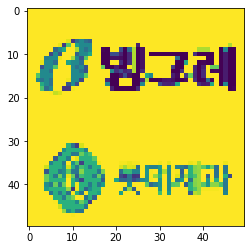

In [427]:
import PIL.Image as pilimg
imgTest1 = pilimg.open('./testImg/test1.png')
# imgTest1.show()
imgTest1 = np.array(imgTest1)

%matplotlib inline 
plt.imshow(imgTest1)

In [428]:
imgTest1.shape

(50, 50)

In [429]:
img=np.array(pilimg.open('./testImg/test1.png').convert('RGB'))
# img.reshape(50*50*3,).shape
preTest = model.predict(img.reshape(50*50*3,))
# preTest.round(2), preTest.shape

ValueError: in user code:

    File "C:\Users\ahasu\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\ahasu\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ahasu\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\ahasu\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\ahasu\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ahasu\AppData\Roaming\Python\Python39\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_21" "                 f"(type Sequential).
    
    Input 0 of layer "dense_160" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer "sequential_21" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=uint8)
      • training=False
      • mask=None
